In [11]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', context='talk')

import statsmodels.tsa.api as smt

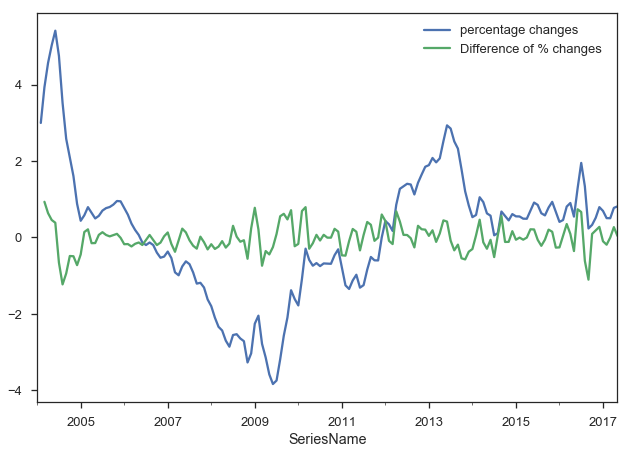

In [7]:
# Read data
df = pd.read_csv('Data/ZHVI/VAR_test6.csv',index_col=0)
df.index = pd.DatetimeIndex(df.index)
#df.head()
city="Vegas"
y=df[city]
y=y["2004-01-01":]
y=y.pct_change()
z=y*100       #The percentage changes 
ax = z.plot(label='percentage changes')
z=z.dropna()
z.diff().dropna().plot(label='Difference of % changes ')
plt.legend()

#Notice that the first difference of percentage changes looks closer to a stationary series.

In [8]:
#Notice that the first difference of percentage changes looks closer to a stationary series. To confirm this, one can
# do the Augmented Dickey–Fuller test:
# We want the second returned result (pvalue) to be small, say <0.05  

import statsmodels.tsa.stattools as tsa

print(tsa.adfuller(z))

# The test shows that the series is not stationary. Thus we differentiate it and run the test
# again. The differentiated series is closer to being stationary.

w=z.diff().dropna()
print(tsa.adfuller(w))



(-1.7882345982913697, 0.38631833518028791, 13, 146, {'1%': -3.4759527332353084, '5%': -2.8815480712411028, '10%': -2.5774387652467632}, 18.684522322918383)
(-2.9004997279662947, 0.045289916762628599, 12, 146, {'1%': -3.4759527332353084, '5%': -2.8815480712411028, '10%': -2.5774387652467632}, 21.166682216686297)


/Users/cristiangavrus/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


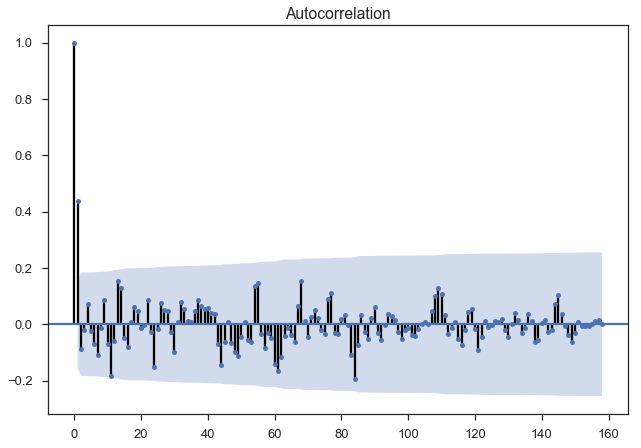

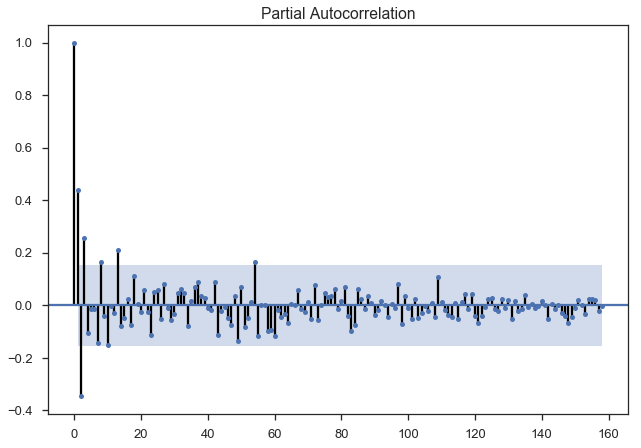

In [9]:
# We plot the ACF and PACF. 

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  

plot_acf(w)

plt.figure()

plot_pacf(w)  

plt.figure()

# Other ways to plot the ACF and PACF:
# from pandas.plotting import autocorrelation_plot
# autocorrelation_plot(z)

# Another way to plot ACF and PACF:
# from statsmodels.tsa.stattools import acf, pacf

# lag_acf = acf(z)
# plt.plot(lag_acf)
# plt.axhline(y=0,linestyle='--',color='gray')
# plt.axhline(y=-1.96/np.sqrt(len(z)),linestyle='--',color='gray')
# plt.axhline(y=1.96/np.sqrt(len(z)),linestyle='--',color='gray')
# plt.title('Autocorrelation Function')

2005-01-01    0.529107
2005-02-01    0.332505
2005-03-01    0.736727
2005-04-01    0.835753
2005-05-01    0.500996
Freq: MS, dtype: float64


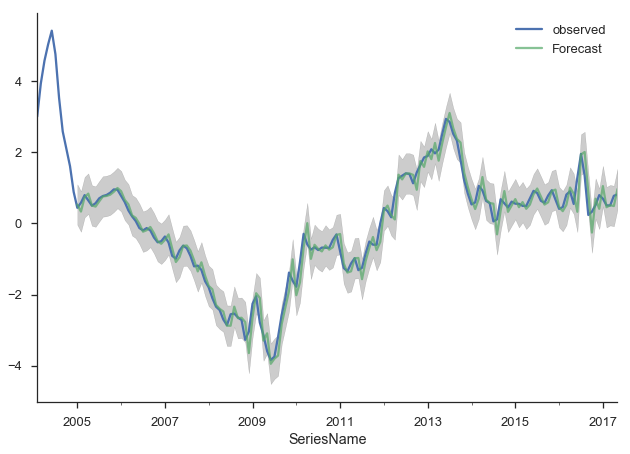

In [13]:
# The plots indicate that neither a pure AR(p) or MA(q) for differences would be adequate. Thus we look for general 
# ARIMA(p,1,q) models
# For simplicity, we begin with a ARIMA(1,1,1) model

model=smt.SARIMAX(z, trend='c', order=(1, 1, 1))
res=model.fit()
pred = res.get_prediction(start='2005-01-01')
pred_ci = pred.conf_int()
ax = z.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
plt.legend()
sns.despine()

print(pred.predicted_mean.head())

In [14]:
# We look at all ARIMA(p,1,q) models for p,q between 0-10 and choose the one with minimum AIC 
# or BIC. 
# Warning: this approach may encounter the difficulty of overfitting in estimation

mod={}

for p in range(1,3):
    for q in range(1,3):
        mod['(p,q)'] = smt.SARIMAX(z, trend='c', order=(p, 1, q))
        res = mod['(p,q)'].fit()
# tsplot(res.resid[2:], lags=24)
        print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                  Vegas   No. Observations:                  160
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -29.112
Date:                Mon, 24 Jul 2017   AIC                             66.223
Time:                        20:01:13   BIC                             78.524
Sample:                    02-01-2004   HQIC                            71.218
                         - 05-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0114      0.037     -0.306      0.759      -0.084       0.061
ar.L1          0.0812      0.095      0.853      0.394      -0.105       0.268
ma.L1          0.6272      0.089      7.048      0.0

/Users/cristiangavrus/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:                  Vegas   No. Observations:                  160
Model:               SARIMAX(1, 1, 2)   Log Likelihood                 -28.577
Date:                Mon, 24 Jul 2017   AIC                             67.153
Time:                        20:01:14   BIC                             82.529
Sample:                    02-01-2004   HQIC                            73.397
                         - 05-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0111      0.045     -0.249      0.804      -0.099       0.076
ar.L1         -0.0961      0.637     -0.151      0.880      -1.344       1.152
ma.L1          0.8363      0.631      1.325      0.1

/Users/cristiangavrus/anaconda/lib/python3.6/site-packages/statsmodels/tsa/statespace/tools.py:405: RuntimeWarning: invalid value encountered in sqrt
  x = r / ((1 - r**2)**0.5)
/Users/cristiangavrus/anaconda/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:475: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[:nlags + 1] / avf[0]
/Users/cristiangavrus/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/cristiangavrus/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/cristiangavrus/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


ValueError: On entry to DLASCL parameter number 5 had an illegal value